### Analysis to add ###
~~CV IKI by BF group~~  
~~CV IKI for each word~~   
Words with lowest/highest CV IKI  
CV IKI for each bigram  
Bigrams with lowest/highest CV IKI  
Difference in word group CV IKI values, between individuals  

Delta IKI across repetitions for one IKI position within the word (rather than averaging across positions)

Typing time by BF  
Typing time for each word  
Quickest/slowest words  
Typing time for bigrams  
For each bigram and by BF
Quickest/slowest bigrams

Onset delay by BF  
Onset delay for each word  
Words with fastest/slowest onset delay  
Onset delay for each bigram  
Bigrams with fastest/slowest onset delay
    
Total error count by word type  
WF and BF  
Total error count for each word  
Words with highest/lowest errors  
Total error count for each bigram
Bigrams with highest/lowest errors  
Avg. edit distance of errors by word type  
WF and BF

In [3]:
# importing experiment data
import numpy as np
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt
from scipy.stats import variation

## will need to edit path for different computers and files

## Desktop
og_df = pd.read_csv(r'/home/rubi/Desktop/Github/typingexp/typing_task_analysis/p01_pat_03042022_test_typingtask_norepeats_2022_Mar_04_1519.csv')
# og_df = pd.read_csv(r'/home/rubi/Desktop/Github/typingexp/typing_task_analysis/p02_ryan_03_17_22_test_typingtask_norepeats_2022_Mar_17_1126.csv')
# og_df = pd.read_csv(r'/home/rubi/Desktop/Github/typingexp/typing_task_analysis/p03_rmr_03302022_test_typingtask_norepeats_2022_Mar_30_1633.csv')
# og_df = pd.read_csv(r'/home/rubi/Desktop/Github/typingexp/typing_task_analysis/p04_AK_04042022_test_typingtask_norepeats_2022_Apr_04_1027.csv')

## Laptop
# og_df = pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/p01_pat_03042022_test_typingtask_norepeats_2022_Mar_04_1519.csv')

In [74]:
### EDIT FOR ANY TRIALS YOU WANT TO IMMEDIATELY EXCLUDE ###

## deleting first 3 practice trials
df = (og_df.drop(labels=[0, 1, 2], axis=0)).reset_index(drop = True)

In [75]:
## list of all strings
all_strings = ['there', 'think', 'about', 'would', 'lucky', 'buddy',
          'cheer', 'theme', 'belly', 'champ', 'puppy', 'vodka',
          'tithe', 'therm', 'haole', 'cooed', 'faqir', 'druze',
          'edthe', 'heond', 'kremp', 'isvar', 'zibja', 'pykka']

## string groupings by word frequency (WF)
mostfam = ['there', 'think', 'about', 'would', 'lucky', 'buddy']
semifam = [ 'cheer', 'theme', 'belly', 'champ', 'puppy', 'vodka']
unfam = ['tithe', 'therm', 'haole', 'cooed', 'faqir', 'druze']
pseudo = ['edthe', 'heond', 'kremp', 'isvar', 'zibja', 'pykka']

## string groupings by bigram frequency (BF)
highbf = ['there', 'think',  'cheer', 'theme', 'tithe', 'therm', 'edthe', 'heond']
medbf = ['about', 'would', 'belly', 'champ', 'haole', 'cooed', 'kremp', 'isvar']
lowbf = ['lucky', 'buddy', 'puppy', 'vodka', 'faqir', 'druze', 'zibja', 'pykka']

## list of string groupings
WF_types = [mostfam, semifam, unfam, pseudo]
BF_types = [highbf, medbf, lowbf]

In [76]:
## expanding nested key_resp.rt values into separate columns, making new dataframe, and turning values back into floats from strings
stripped_rts_1 = ((df['key_resp_1.rt'].str.strip('[,]')).dropna()).str.split(',', expand = True)
stripped_rts_2 = ((df['key_resp_2.rt'].str.strip('[,]')).dropna()).str.split(',', expand = True)
rts_intocolumns = (pd.concat([stripped_rts_1, stripped_rts_2])).reset_index(drop = True)

## renames rt columns to automatically match dataset
DF = rts_intocolumns
renamed_rt = DF.rename(columns = { 0:'key_resp.rt.%s' %(0+1) })
for n in range(0, len(DF.columns)):
    renamed_rt = renamed_rt.rename(columns = { n:'key_resp.rt.%s' %(n+1) })
expanded_rts = renamed_rt.astype(float).fillna(0) ##replacing NaNs with zeroes

## expanding nested key_resp.keys values into separate columns and making new dataframe
stripped_keys_1 = ((df['key_resp_1.keys'].str.strip('[,]')).dropna()).str.split(',', expand = True)
stripped_keys_2 = ((df['key_resp_2.keys'].str.strip('[,]')).dropna()).str.split(',', expand = True)
keys_intocolumns = (pd.concat([stripped_keys_1, stripped_keys_2])).reset_index(drop = True)

## renames key columns to automatically match dataset
DF = keys_intocolumns
expanded_keys = DF.rename(columns = { 0:'key_resp.keys.%s' %(0+1) })
for n in range(0, len(DF.columns)):
    expanded_keys = expanded_keys.rename(columns = { n:'key_resp.keys.%s' %(n+1) })
    
## getting rid of apostrophes and spaces in key values
cols_to_change = (expanded_keys.iloc[:, 0:])
for col in cols_to_change:
    expanded_keys[col] = expanded_keys[col].str.replace("'", "")
    expanded_keys[col] = expanded_keys[col].str.replace(" ", "")
    
## combining key_resp.keys into one simple string to easily represent typed responses
responses_1 = pd.DataFrame((df['key_resp_1.keys'].str.replace("[', ]", "", regex=True).str.strip("[]")).dropna()).rename(columns = {'key_resp_1.keys':'resp_string'})
responses_2 = pd.DataFrame((df['key_resp_2.keys'].str.replace("[', ]", "", regex=True).str.strip("[]")).dropna()).rename(columns = {'key_resp_2.keys':'resp_string'})
responses = (pd.concat([responses_1, responses_2])).reset_index(drop = True)

## identifying bigrams in words to add to larger dataframe
## defining function that separates words in to bigrams
def bi_byword(word):
    bi_results = []
    for y in range(0, (len(word)-1)):
        bigram = word[y] + word[y+1]
        bi_results.append(bigram)
    return bi_results

## defining function that separates all words into bigrams
def bi_allwords(string_type):
    bigrams = []
    for word in df['string']:
        bigrams.append(bi_byword(word))
    return bigrams

all_bigrams = pd.DataFrame(bi_allwords(all_strings))
all_bigrams.columns = ['bi_1', 'bi_2', 'bi_3', 'bi_4']

In [77]:
## combining expanded rt, expanded keys, and response string values with column for strings typed each trial to create more useful dataframe
    ## (does not have all the random timing data of other events occuring during the task)
main_df = pd.concat([all_bigrams, expanded_keys, expanded_rts, responses], axis = 1)
main_df.insert(0, 'string', df['string'], True)

## creating column for WF type for each trial
main_df['WF Type'] = ""
for index, data in main_df.iterrows():
    if main_df.loc[index, 'string'] in mostfam:
        main_df.loc[index, 'WF Type'] = 'mostfam'
    if main_df.loc[index, 'string'] in semifam:
        main_df.loc[index, 'WF Type'] = 'semifam'
    if main_df.loc[index, 'string'] in unfam:
        main_df.loc[index, 'WF Type'] = 'unfam'
    if main_df.loc[index, 'string'] in pseudo:
        main_df.loc[index, 'WF Type'] = 'pseudo'

## creating column for BF type for each trial
main_df['BF Type'] = ""
for index, data in main_df.iterrows():
    if main_df.loc[index, 'string'] in highbf:
        main_df.loc[index, 'BF Type'] = 'highbf'
    if main_df.loc[index, 'string'] in medbf:
        main_df.loc[index, 'BF Type'] = 'medbf'
    if main_df.loc[index, 'string'] in lowbf:
        main_df.loc[index, 'BF Type'] = 'lowbf'

In [78]:
main_df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(main_df)

,string,bi_1,bi_2,bi_3,bi_4,key_resp.keys.1,key_resp.keys.2,key_resp.keys.3,key_resp.keys.4,key_resp.keys.5,...,key_resp.rt.1,key_resp.rt.2,key_resp.rt.3,key_resp.rt.4,key_resp.rt.5,key_resp.rt.6,key_resp.rt.7,resp_string,WF Type,BF Type
0,kremp,kr,re,em,mp,k,r,e,m,p,...,0.996642,1.116656,1.156616,1.372525,1.548582,0.0,0.0,kremp,pseudo,medbf
1,cheer,ch,he,ee,er,c,h,e,e,r,...,0.671812,0.855727,0.919855,1.087847,1.167753,0.0,0.0,cheer,semifam,highbf
2,tithe,ti,it,th,he,t,i,t,h,e,...,0.758538,0.918603,0.966618,1.222568,1.246556,0.0,0.0,tithe,unfam,highbf
3,puppy,pu,up,pp,py,p,u,p,p,t,...,0.615785,0.767870,0.887859,1.007913,1.143788,0.0,0.0,puppt,semifam,lowbf
4,about,ab,bo,ou,ut,a,b,o,u,t,...,0.601563,0.785572,0.897589,0.969532,1.025468,0.0,0.0,about,mostfam,medbf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,lucky,lu,uc,ck,ky,l,u,c,k,y,...,0.624745,0.832739,0.960702,1.056617,1.256741,0.0,0.0,lucky,mostfam,lowbf
236,tithe,ti,it,th,he,t,i,t,h,e,...,0.607898,0.751954,0.847952,0.919946,1.023957,0.0,0.0,tithe,unfam,highbf
237,pykka,py,yk,kk,ka,p,y,k,k,a,...,0.720007,1.039963,1.184078,1.311894,1.416010,0.0,0.0,pykka,pseudo,lowbf
238,theme,th,he,em,me,t,h,e,m,e,...,0.566274,0.662309,0.782323,0.878353,0.942219,0.0,0.0,theme,semifam,highbf


In [79]:
## make dataframe of bigram IKIs
## bigram / trial # / string / IKI / bf type / resp_string / string type 

def bigram_byrow():
    bigrams = []
    for index, row in keys_intocolumns.iterrows():
        for column in range(0, (len(keys_intocolumns.columns) - 1)):
            if keys_intocolumns[column][index] != None and keys_intocolumns[column + 1][index] != None:
                bigram = keys_intocolumns[column][index] + keys_intocolumns[column + 1][index]
                iki = (main_df['key_resp.rt.%(second)d' % {'second':  column + 2 }][index] - main_df['key_resp.rt.%(first)d' % { 'first': column +1 }][index])
                bigrams.append([bigram, index, iki, main_df['string'][index], main_df['resp_string'][index]])
    return(bigrams)
    
bigram_df = (pd.DataFrame(bigram_byrow())).rename(columns={0: "Bigram", 1: "Trial #", 2: "IKI", 3: "string", 4: "resp_string"})
bigram_df

,Bigram,Trial #,IKI,string,resp_string
0,'k' 'r',0,0.120014,kremp,kremp
1,'r' 'e',0,0.039960,kremp,kremp
2,'e' 'm',0,0.215909,kremp,kremp
3,'m' 'p',0,0.176057,kremp,kremp
4,'c' 'h',1,0.183915,cheer,cheer
...,...,...,...,...,...
960,'m' 'e',238,0.063866,theme,theme
961,'b' 'u',239,0.152043,buddy,buddy
962,'u' 'd',239,0.079864,buddy,buddy
963,'d' 'd',239,0.144082,buddy,buddy


In [82]:
## defining function to make dataframe of only correct trials
def correct_filter(DF):
    corr_temp = []
    for index, data in DF.iterrows():
        if data['string'] == data['resp_string']: ## compares presented string with typed response
            corr_temp.append(DF.iloc[index])
    corr = pd.DataFrame(corr_temp).reset_index(drop=True)
    return corr
corr_df = correct_filter(main_df)

## defining function to filter for only trial rts
def rt_columns(DF):
    rt_columns = ['string']
    for column in DF:
        if 'key_resp.rt' in column:
            rt_columns.append(column)
    rts = pd.DataFrame(DF[rt_columns])
    return rts

## making dataframe of only correct trial rts
corr_rts = rt_columns(corr_df)

## defining function to make dataframe of only incorrect trials
def incorrect_filter(DF):
    incorr_temp = []
    for index, data in DF.iterrows():
        if data['string'] != data['resp_string']: ## compares presented string with typed response
            incorr_temp.append(DF.iloc[index])
    incorr = pd.DataFrame(incorr_temp).reset_index(drop=True)
    return incorr
incorr_df = incorrect_filter(main_df)

## making dataframe of only incorrect trial rts
incorr_rts = rt_columns(incorr_df)

## making filtered dataframes by word frequency
mostfam_df = main_df[main_df['string'].isin(mostfam)]
semifam_df = main_df[main_df['string'].isin(semifam)]
unfam_df = main_df[main_df['string'].isin(unfam)]
pseudo_df = main_df[main_df['string'].isin(pseudo)]

In [83]:
## making dataframe of only rts from all trials
all_rts = expanded_rts
## inserting column containing the string typed during each trial, if it hasn't already been inserted
if ((all_rts.iloc[:, 0]).dtype) != object:
    all_rts.insert(0, 'string', df['string'], True)

## making dataframes with rts by word frequency type
mostfam_rts = (rt_columns(mostfam_df)).reset_index(drop=True)
semifam_rts = (rt_columns(semifam_df)).reset_index(drop=True)
unfam_rts = (rt_columns(unfam_df)).reset_index(drop=True)
pseudo_rts = (rt_columns(pseudo_df)).reset_index(drop=True)

## Onset Delay

In [84]:
## defining function for calculating onset delays for different WF categories
def onset_delay(DF):
    return DF['key_resp.rt.1']

## defining function for calculating average onset delay for different WF categories
def avg_onset_delay(DF):
    return np.mean(DF['key_resp.rt.1'])

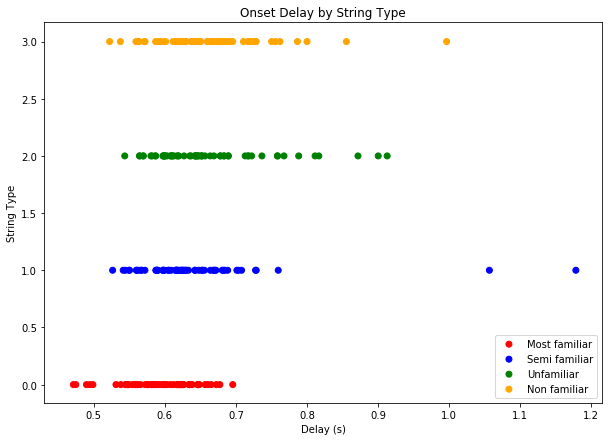

In [85]:
## plotting onset delay as scatter plot
plt.figure(figsize=(10, 7))
mostfam_scatter = plt.scatter(onset_delay(mostfam_df), [0] * len(onset_delay(mostfam_df)), c=['red'] * len(onset_delay(mostfam_df)), label='Most familiar')
semifam_scatter = plt.scatter((onset_delay(semifam_df)), [1] * len(onset_delay(semifam_df)), c=['blue'] * len(onset_delay(semifam_df)), label='Semi familiar')
unfam_scatter = plt.scatter((onset_delay(unfam_df)), [2] * len(onset_delay(unfam_df)), c=['green'] * len(onset_delay(unfam_df)), label='Unfamiliar')
pseudo_scatter = plt.scatter((onset_delay(pseudo_df)), [3] * len(onset_delay(pseudo_df)), c=['orange'] * len(onset_delay(pseudo_df)), label='Non familiar')

plt.xlabel("Delay (s)")
plt.ylabel("String Type")
plt.title("Onset Delay by String Type")
plt.legend(loc = "lower right")

plt.show()

Text(0.5, 1.0, 'Onset Delay by String Type')

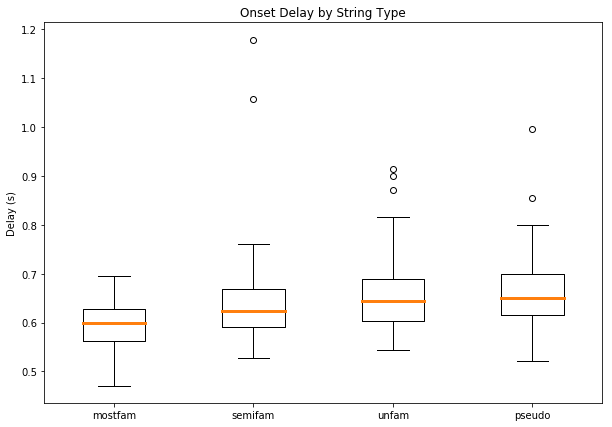

In [86]:
## plotting onset delay as box and whisker
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([ onset_delay(mostfam_df), onset_delay(semifam_df), onset_delay(unfam_df), onset_delay(pseudo_df)])

colors = ['#0000FF', '#00FF00','#FFFF00', '#FF00FF']

ax.set_xticklabels(['mostfam', 'semifam',
                    'unfam', 'pseudo'])
for median in bp['medians']:
    median.set(linewidth = 3)

plt.xlabel("")
plt.ylabel("Delay (s)")
plt.title("Onset Delay by String Type")

## Typing Time

In [88]:
## defining function to determine time spent typing each trial (effectively speed)
def time_typing(DF):
    speeds = []
    key_1 = len(DF.columns)
    for index, data in DF.iterrows():
        for n in range(-1, -(key_1), -1):
            if DF.iloc[index, n] != 0: ## finds last rt value that isn't zero, so typing time is not a negative number
                speed = (DF.iloc[index, n]) - (DF.iloc[index, 1])
                speeds.append(speed)
                break
    return speeds

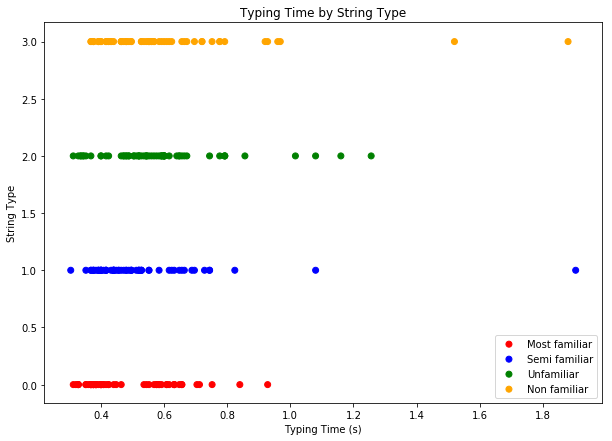

In [89]:
## plotting scatter plot of typing time with legend
plt.figure(figsize=(10, 7))
mostfam_scatter = plt.scatter(time_typing(mostfam_rts), [0] * len(time_typing(mostfam_rts)), c=['red'] * len(time_typing(mostfam_rts)), label='Most familiar')
semifam_scatter = plt.scatter(time_typing(semifam_rts), [1] * len(time_typing(semifam_rts)), c=['blue'] * len(time_typing(semifam_rts)), label='Semi familiar')
unfam_scatter = plt.scatter(time_typing(unfam_rts), [2] * len(time_typing(unfam_rts)), c=['green'] * len(time_typing(unfam_rts)), label='Unfamiliar')
pseudo_scatter = plt.scatter(time_typing(pseudo_rts), [3] * len(time_typing(pseudo_rts)), c=['orange'] * len(time_typing(pseudo_rts)), label='Non familiar')

plt.xlabel("Typing Time (s)")
plt.ylabel("String Type")
plt.title("Typing Time by String Type")
plt.legend(loc= "lower right")

plt.show()

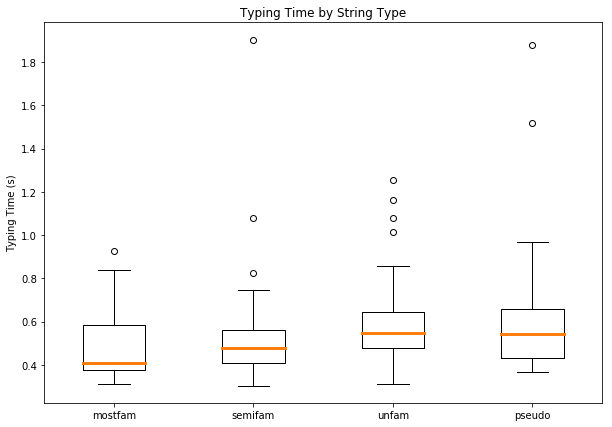

In [90]:
## plotting typing time as box and whisker
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([ time_typing(mostfam_rts), time_typing(semifam_rts), time_typing(unfam_rts), time_typing(pseudo_rts)])

colors = ['#0000FF', '#00FF00','#FFFF00', '#FF00FF']

ax.set_xticklabels(['mostfam', 'semifam',
                    'unfam', 'pseudo'])
for median in bp['medians']:
    median.set(linewidth = 3)
    
plt.xlabel("")
plt.ylabel("Typing Time (s)")
plt.title("Typing Time by String Type")

plt.show()

## IKI Variables

In [92]:
### For all these functions, the dataframe variable (DF) needs to be a reaction time DF with associated strings in column 1 
###(ex. all_rts, corr_rts, incorr_rts)

## defining function to determine interkey intervals for each trial
def iki(DF):
    ints_byword = []
    last_key = len(DF.columns) - 1   
    for index, data in DF.iterrows():
        intervals = []
        for n in range(1, last_key):
            interval = (DF.iloc[index, n + 1]) - (DF.iloc[index, n])
            intervals.append(interval)
        ints_byword.append(intervals)
    all_ints = pd.DataFrame(ints_byword)
    all_ints[all_ints < 0] = 0  ## making all negative values in initial output 0
    all_ints.insert(0, 'string', DF['string'], True) ## adding in column containing the string typed each trial
    return all_ints

## defining function to determine coefficient of variation (CV) across interkey intervals (IKIs) for trials with the same word
def cv_byword(string, DF):
    arr = iki(DF)
    sort_byword = []
    for index, data in arr.iterrows():
        if DF['string'][index] == string:
            sort_byword.append(data)
    iki_byword = pd.DataFrame(sort_byword)
    temp = iki_byword.drop(['string'], axis=1) ## temporatily dropping 'string' column to calculate CV across columns
    iki_cv = (variation(temp, axis=0)).tolist()
    iki_cv.insert(0, string)
    return iki_cv
    
## defining function to make dataframe of all IKI-CVs by word
def cv_all(str_type, DF):
    cvs = []
    for x in str_type:
        y = cv_byword(x, DF)
        cvs.append(y)
    all_cvs = (pd.DataFrame(cvs)).dropna(axis=1) ## dropping columns with NaNs -- IKI-CVs of additive errors, not necessary to analyze
    return all_cvs

## defining function to determine average IKI-CV by word freq. type
def avg_cv(str_type, DF):
    arr = cv_all(str_type, DF)
    avgs = []
    last_row = len(arr.columns)
    for n in range(1, last_row):
        y = arr[n].mean()
        avgs.append(y)
    return avgs

In [93]:
## WIP -- need to get strings out of list to get mean

# defining function to find average IKI across all string positions for each trial
# def avg_iki(str_type, DF):
#     all_ikis = iki(DF)
#     sort_byword = []
#     for index, data in all_ikis.iterrows():
#             if all_ikis['string'][index] in str_type:
#                 sort_byword.append(data)
#     iki_byword = pd.DataFrame(sort_byword)
#     iki_byword.reset_index(drop=True, inplace=True)
#     iki_list = iki_byword.values.tolist()
#     iki_avgs = sum(iki_list)/len(iki_list)
#     return iki_avgs

In [94]:
all_rts

,string,key_resp.rt.1,key_resp.rt.2,key_resp.rt.3,key_resp.rt.4,key_resp.rt.5,key_resp.rt.6,key_resp.rt.7
0,kremp,0.996642,1.116656,1.156616,1.372525,1.548582,0.0,0.0
1,cheer,0.671812,0.855727,0.919855,1.087847,1.167753,0.0,0.0
2,tithe,0.758538,0.918603,0.966618,1.222568,1.246556,0.0,0.0
3,puppy,0.615785,0.767870,0.887859,1.007913,1.143788,0.0,0.0
4,about,0.601563,0.785572,0.897589,0.969532,1.025468,0.0,0.0
...,...,...,...,...,...,...,...,...
235,lucky,0.624745,0.832739,0.960702,1.056617,1.256741,0.0,0.0
236,tithe,0.607898,0.751954,0.847952,0.919946,1.023957,0.0,0.0
237,pykka,0.720007,1.039963,1.184078,1.311894,1.416010,0.0,0.0
238,theme,0.566274,0.662309,0.782323,0.878353,0.942219,0.0,0.0


In [95]:
## WIP

## defining function to determing CV IKI of each bigram
def cv_bybg(bigram, DF):
    arr = iki(DF)
    arr.insert(1, 'bi_1', main_df['bi_1'], True)
    print(arr)
    sort_byword = []
    for index, data in arr.iterrows():
        if DF['string'][index] == bigram:
            sort_byword.append(data)
    iki_bybi = pd.DataFrame(sort_byword)
    print(iki_bybi)
    temp = iki_bybi.drop(['string'], axis=1) ## temporatily dropping 'string' column to calculate CV across columns
    iki_cv = (variation(temp, axis=0)).tolist()
    iki_cv.insert(0, string)
    return iki_cv

In [96]:
cv_bybg('th', all_rts)

    string bi_1         0         1         2         3    4    5
0    kremp   kr  0.120014  0.039960  0.215909  0.176057  0.0  0.0
1    cheer   ch  0.183915  0.064129  0.167991  0.079907  0.0  0.0
2    tithe   ti  0.160064  0.048015  0.255950  0.023987  0.0  0.0
3    puppy   pu  0.152085  0.119990  0.120054  0.135874  0.0  0.0
4    about   ab  0.184008  0.112017  0.071943  0.055936  0.0  0.0
..     ...  ...       ...       ...       ...       ...  ...  ...
235  lucky   lu  0.207993  0.127963  0.095915  0.200124  0.0  0.0
236  tithe   ti  0.144056  0.095998  0.071994  0.104011  0.0  0.0
237  pykka   py  0.319956  0.144115  0.127815  0.104116  0.0  0.0
238  theme   th  0.096035  0.120014  0.096030  0.063866  0.0  0.0
239  buddy   bu  0.152043  0.079864  0.144082  0.231907  0.0  0.0

[240 rows x 8 columns]
Empty DataFrame
Columns: []
Index: []


KeyError: "['string'] not found in axis"

In [ ]:
## plotting digraph latency variations by WF type (includes error trials)
## NOTE: run twice for tick marks / label sizes to update -- dunno why
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
mostfam_plot = plt.plot(avg_cv(mostfam, all_rts), color='red', label='High WF')
semifam_plot = plt.plot(avg_cv(semifam, all_rts), color='blue', label='Medium WF')
unfam_plot = plt.plot(avg_cv(unfam, all_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(avg_cv(pseudo, all_rts), color='orange', label='Pseudo')

## Set general font size
plt.rcParams['font.size'] = '25'

## Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(25)

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Interval position in string")
plt.ylabel("Average CV")
# plt.ylim([0.1, 0.6])
plt.title("Average CV of Interkey Interval by Word Frequency", pad=30)
plt.legend(loc="upper right")

plt.savefig('ian_iki.png')

plt.show()

In [ ]:
## plotting digraph latency variations by WF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
mostfam_plot = plt.plot(avg_cv(mostfam, corr_rts), color='red', label='High WF')
semifam_plot = plt.plot(avg_cv(semifam, corr_rts), color='blue', label='Medium WF')
unfam_plot = plt.plot(avg_cv(unfam, corr_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(avg_cv(pseudo, corr_rts), color='orange', label='Pseudo')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0.1, 0.6])
plt.title("Average CV of Interkey Interval by WF Type")
plt.legend(loc="upper right")

plt.show()

In [ ]:
## plotting digraph latency variations by BF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
mostfam_plot = plt.plot(avg_cv(highbf, all_rts), color='red', label='High bigram freq.')
semifam_plot = plt.plot(avg_cv(medbf, all_rts), color='blue', label='Medium bigram freq.')
unfam_plot = plt.plot(avg_cv(lowbf, all_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0.1, 0.6])
plt.title("Average CV of Interkey Interval by BF Type")
plt.legend(loc="upper right")

plt.show()

In [ ]:
## plotting digraph latency variations by BF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
mostfam_plot = plt.plot(avg_cv(highbf, corr_rts), color='red', label='High bigram freq.')
semifam_plot = plt.plot(avg_cv(medbf, corr_rts), color='blue', label='Medium bigram freq.')
unfam_plot = plt.plot(avg_cv(lowbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0.1, 0.6])
plt.title("Average CV of Interkey Interval by BF Type")
plt.legend(loc="upper right")

plt.show()

In [ ]:
## plotting digraph latency variations with legend (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
mostfam_plot = plt.plot(avg_cv(highbf, corr_rts), color='red', label='High bigram freq.')
semifam_plot = plt.plot(avg_cv(medbf, corr_rts), color='blue', label='Medium bigram freq.')
unfam_plot = plt.plot(avg_cv(lowbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0.1, 0.6])
plt.title("Average CV of Interkey Interval by BF Type")
plt.legend(loc="upper right")

plt.show()

In [ ]:
## creating dataframe from 'cv_byword' function that is easy to plot
cv_word = 'vodka' # change this for which ever word you want to plot
cv_byword_df = (pd.DataFrame(cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

## plotting digraph latency variations by word (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
mostfam_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# semifam_plot = plt.plot(cv_byword_df, color='red', label='There')



plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0.1, 0.6])
plt.title("Average CV of Interkey Interval by Word")
plt.legend(loc="upper right")

plt.show()

In [ ]:
## defining function to determine delta IKIs by word
def diki(string, DF):
    all_ikis = iki(DF)
    sort_byword = []
    for index, data in all_ikis.iterrows():
            if all_ikis['string'][index] == string:
                sort_byword.append(data)
    iki_byword = pd.DataFrame(sort_byword)
    iki_byword.reset_index(drop=True, inplace=True)
    last_key = len(iki_byword.columns)
    trial_count = len(iki_byword)
    dikis_byword = []
    for index in range(0, trial_count - 1):
        dikis = []
        for n in range(1, last_key):
            diki = abs((iki_byword.iloc[index + 1, n]) - (iki_byword.iloc[index, n])) # solves for delta IKI and makes value absolute
            dikis.append(diki)
        dikis_byword.append(dikis)
    dikis_byword = pd.DataFrame(dikis_byword)
# make a list of row titles (inter-repetition position)
    row_titles = []
    for n in range(1, trial_count):
        y = '%s-%s' %(n, n+1)
        row_titles.append(y)
    dikis_byword.insert(0, 'inter-rep', row_titles)
    return dikis_byword

## defining function to determine average of all delta IKIs within word
def avg_diki_byword(string, DF):
    dikis_byword = diki(string, DF)
    avgs = []
    last_row = len(dikis_byword.columns)
    dikis_byword['mean'] = dikis_byword.mean(axis=1, numeric_only=True)
    meandiki_bypos = dikis_byword['mean']
    return meandiki_bypos

## defining function to determine the average delta IKI by word type -- average of average delta IKI per word
def avg_diki_byWF(str_type, DF):
    allword_dikis = pd.DataFrame()
    for string in str_type:
            dikis_byword = diki(string, DF)
            dikis_byword_df = pd.DataFrame(dikis_byword)
#             print(dikis_byword_df)
            allword_dikis = allword_dikis.append(dikis_byword_df)
    allword_dikis = allword_dikis.reset_index(drop=True)
# get average of word-specific delta IKI averages for each inter-repetition position
    avgiki_bypos = []
    for n in range(1, 10):
        iki_bypos = pd.DataFrame()
        for index, data in allword_dikis.iterrows():
            if allword_dikis['inter-rep'][index] == '%s-%s' %(n, n+1):
                temp = allword_dikis.iloc[index]
#                 print(temp)
                iki_bypos = iki_bypos.append(temp)
        iki_bypos['mean'] = iki_bypos.mean(axis=1)
#         print(iki_bypos)
        double_mean = iki_bypos['mean'].mean(numeric_only=True)
        avgiki_bypos.append(double_mean)
    return avgiki_bypos

In [ ]:
## plotting average delta IKI by WF type (only for correct trials)

plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
mostfam_plot = plt.plot((avg_diki_byword('think', corr_rts)), color='red', label='"Right"')
semifam_plot = plt.plot((avg_diki_byword('there', corr_rts)), color='blue', label='"There"')
unfam_plot = plt.plot((avg_diki_byword('about', corr_rts)), color='green', label='"About"')
pseudo_plot = plt.plot((avg_diki_byword('would', corr_rts)), color='orange', label='"Where"')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Inter-repetition position", labelpad=15)
plt.ylabel("Average interkey interval difference", labelpad=15)
# plt.ylim([0.1, 0.6])
plt.title("Average Interkey Interval Difference by String", pad=40)
plt.legend(loc="upper left")

plt.show()

In [ ]:
## To-Do:
## total number of errors by string type
## total number of errors by string -
## edit distance by string type
## variation of IKI for same bigram across different words and word types

In [ ]:
# bar chart for error by word
# plt.figure(figsize=(15, 7))
# plt.bar(plot_labels, plot_values, color=plot_colors,
#         width=0.4)

# plt.xlabel("")
# plt.ylabel("Total No. of errors")
# plt.title("Errors by String")
# plt.show()